**Library Installation**




In [ ]:
%%capture
!pip install pyspark==3.5.0
!pip install gdown

# **Dataset**

The dataset consists of incidents of crime reported in the city of Chicago from 2001 to 2019. Data is extracted from the Chicago Police Department's **CLEAR** (Citizen Law Enforcement Analysis and Reporting) system.

**Link:** https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2

In [ ]:
data_link = 'https://drive.google.com/u/0/uc?id=1wRGDX25AyYWw2eA771CCbvugxYrRQOtw'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
compressed_file_path = '/content/drive/MyDrive/CrimeInsightsRawData/Crimes_2001_to_Present.csv.zip'
!mkdir -p /content/drive/MyDrive/CrimeInsightsRawData

In [ ]:
%%capture
import gdown
gdown.download(data_link,compressed_file_path)

In [ ]:
!unzip -o /content/drive/MyDrive/CrimeInsightsRawData/Crimes_2001_to_Present.csv.zip -d /content/drive/MyDrive/CrimeInsightsRawData/

Archive:  /content/drive/MyDrive/CrimeInsightsRawData/Crimes_2001_to_Present.csv.zip
  inflating: /content/drive/MyDrive/CrimeInsightsRawData/Crimes_2001_to_Present.csv  
  inflating: /content/drive/MyDrive/CrimeInsightsRawData/__MACOSX/._Crimes_2001_to_Present.csv  


In [ ]:
file_path = '/content/drive/MyDrive/CrimeInsightsRawData/Crimes_2001_to_Present.csv'

# **Data Processing Frameworks**
**Import the libraries needed** :

*   SparkContext allows us to connect to a Spark cluster.  
*   Spark Session which allows us to work with structured data using DataFrames and Datasets.
*   Spark SQL which gives access to a wide variety of tools such as DataFrames, functions, data types and operations such as (select, filter, groupBy, agg)

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from pyspark.sql.functions import *

Set up the configuration for our Spark application

In [ ]:
spark = SparkSession.builder.appName("CrimeInsights")\
.config("spark.driver.memory", "10g")\
.getOrCreate()

**Defining the schema on how we will structure our DataFrame**


*   The column name as a string
*   The data type of the column
*   A Boolean value indicating that null values are allowed in the column.






In [ ]:
schema = StructType([StructField("ID", IntegerType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", IntegerType(), True),
                            StructField("Community Area", IntegerType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", DoubleType(), True),
                            StructField("Y Coordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

Read the CSV file, applies the schemma and stores the data in a DataFrame



In [ ]:
df = spark.read.csv(file_path,header=True,schema=schema)
df.show()

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|11646166|   JC213529|09/01/2018 12:01:...|082XX S INGLESIDE...|0810|               THEFT|           OVER $500|           RESIDENCE| false|    true|0631| 

Drop the columns that are not relevant to our analysis and convert the date column to a timestamp format.

This is how our data schema looks like after we have dropped specific columns from the DataFrame (df), converting one of the remaining columns ('date') to a timestamp format, and then displaying the resulting DataFrame.

In [ ]:

casted_df = df.withColumn('Date',to_timestamp(col('date'),'MM/dd/yyyy hh:mm:ss a'))
# casted_df.show()

In [ ]:
parquet_path = '/content/drive/MyDrive/CrimeInsightParquet/'

In [ ]:
casted_df.write.parquet(parquet_path,mode='overwrite')

In [ ]:
parqued_df = casted_df
# parqued_df = spark.read.parquet(parquet_path)
# parqued_df.count()

In [ ]:
CrimemMapping = [
    ("THEFT", False),
    ("BATTERY", True),
    ("CRIMINAL DAMAGE", True),
    ("NARCOTICS", False),
    ("ASSAULT", True),
    ("OTHER OFFENSE", False),
    ("BURGLARY", False),
    ("MOTOR VEHICLE THEFT", False),
    ("DECEPTIVE PRACTICE", False),
    ("ROBBERY", True),
    ("CRIMINAL TRESPASS", True),
    ("WEAPONS VIOLATION", True),
    ("PROSTITUTION", False),
    ("OFFENSE INVOLVING CHILDREN", True),
    ("PUBLIC PEACE VIOLATION", True),
    ("SEX OFFENSE", True),
    ("CRIM SEXUAL ASSAULT", True),
    ("INTERFERENCE WITH PUBLIC OFFICER", True),
    ("LIQUOR LAW VIOLATION", False),
    ("GAMBLING", False),
    ("ARSON", True),
    ("HOMICIDE", True),
    ("CRIMINAL SEXUAL ASSAULT", True),
    ("KIDNAPPING", True),
    ("STALKING", True),
    ("INTIMIDATION", True),
    ("CONCEALED CARRY LICENSE VIOLATION", True),
    ("OBSCENITY", False),
    ("PUBLIC INDECENCY", True),
    ("NON-CRIMINAL", False),
    ("OTHER NARCOTIC VIOLATION", False),
    ("HUMAN TRAFFICKING", True),
    ("NON - CRIMINAL", False),
    ("RITUALISM", False),
    ("NON-CRIMINAL (SUBJECT SPECIFIED)", False),
    ("DOMESTIC VIOLENCE", True)
]
Violent_Crimes = set()
for crime in CrimemMapping:
  if crime[1]:
    Violent_Crimes.add(crime[0])

# **Counting Rows in the Dataframe**

1. Drop the rows with missing values, Total number of rows in the DataFrame parqued_df including rows with missing or null values.

2. Filter out the rows that are not of interest to focus on specific categories, (fieltered_df) returns a DataFrame that contains the filtered rows

# **Data Tranformation**

1. The first 'when' clause checks if the "Primary_Type" is either 'CRIM SEXUAL ASSAULT' or 'PROSTITUTION'. If the condition is met, it assigns the value 'SEX OFFENSE' to the "Primary_Type" column.

2. The second when clause checks if the "Primary_Type" is either 'WEAPONS VIOLATION' or 'INTERFERENCE WITH PUBLIC OFFICER'. If the condition is met, it assigns the value 'PUBLIC PEACE VIOLATION' to the "Primary_Type" column.
3. The third when clause checks if the "Primary_Type" is 'ARSON'. If the condition is met, it assigns the value 'CRIMINAL TRESPASS' to the "Primary_Type" column.
4. The otherwise clause is used as a fallback, so if none of the previous conditions are met, it keeps the original value of the "Primary_Type" column.

In [ ]:
transformed_df = parqued_df.withColumnRenamed("Primary Type","Primary_Type")
transformed_df = transformed_df.withColumn("Primary_Type",
          when((col("Primary_Type").isin ('CRIM SEXUAL ASSAULT','PROSTITUTION')) ,'SEX OFFENSE')
          .when((col("Primary_Type").isin('WEAPONS VIOLATION','INTERFERENCE WITH PUBLIC OFFICER')) ,'PUBLIC PEACE VIOLATION')
          .when((col("Primary_Type") == 'ARSON') ,'CRIMINAL TRESPASS')
          .otherwise(col("Primary_Type")))

# filtered_df.show()
transformed_df = transformed_df.withColumn("ViolentCrime",
          when((col("Primary_Type").isin (Violent_Crimes)) ,"Yes")
          .otherwise("No"))

# filtered_df.show()

transformed_df=transformed_df.withColumn("Week", weekofyear(col('date')))
transformed_df=transformed_df.withColumn("DayOfWeek", dayofweek(col('date')))

In [ ]:
filtered_parquet_path = '/content/drive/MyDrive/CrimeInsightParquetFiltered/'

In [ ]:
filtered_csv_path = '/content/drive/MyDrive/CrimeInsightCSVFiltered/'

In [ ]:
# transformed_df.coalesce(1).write.parquet(filtered_parquet_path,mode='overwrite')

In [ ]:
transformed_df.coalesce(1).write.csv(filtered_csv_path,mode='overwrite',header = True)

In [ ]:
transformed_df= spark.read.parquet(filtered_parquet_path)

In [ ]:
transformed_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary_Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: double (nullable = true)
 |-- Y Coordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: date (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- ViolentCrime: string (nullable = false)
 |-- Week: integer (nullable = true)
 |-- DayOfWeek: in

In [ ]:
drop_columns = ['date','ID','Case Number','FBI Code','Updated On','IUCR','X Coordinate','Y Coordinate','Arrest','Location','Domestic','Description','Block','Latitude','Longitude','District','Ward']
transformed_df = transformed_df.drop(*drop_columns)
transformed_df = transformed_df.na.drop()
# transformed_df.count()

In [ ]:
# filter_values = {'STALKING','OBSCENITY','NON-CRIMINAL (SUBJECT SPECIFIED)','GAMBLING','NON - CRIMINAL','LIQUOR LAW VIOLATION','PUBLIC INDECENCY','HUMAN TRAFFICKING','INTIMIDATION','CONCEALED CARRY LICENSE VIOLATION','NON-CRIMINAL','OTHER NARCOTIC VIOLATION'}
# non_na_df = non_na_df.withColumnRenamed('Primary Type','Primary_Type')
# filtered_df = non_na_df.filter(~non_na_df.Primary_Type.isin(filter_values))
# filtered_df.count()
# filtered_df = non_na_df

In [ ]:
transformed_df.printSchema()

root
 |-- Primary_Type: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- ViolentCrime: string (nullable = true)
 |-- Week: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)



**Import Machine Learning libraries and vectorizers to perform feature extraction and train our models**


*   VectorAssembler will allow us to transform our input data in vector format.
*   StringIndexer allows us to use a feature transformer that encodes a string column of labels into numbers and VectorIndexer which automatically identify and index categorical features.
*   IndexToString convert numerical labels to their original string labels after the model has made its predictions.
*   RandomForestClassifier which is a machine learning classifier that leverages a collection of decision trees to make predictions based on a majority vote.
*   MulticlassClassificationEvaluator used to evaluate the performance of the models
*   Pipeline used to develop a machine learning pipeline











In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipelinea
from pyspark.mllib.tree import RandomForest
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

Extract the week of the year from the date column and drop the date column

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

string_columns = ['Primary_Type','Location Description','Beat','ViolentCrime']
indexers = [StringIndexer(inputCol=column, outputCol= column+'_index').setHandleInvalid("skip").fit(transformed_df) for column in string_columns ]
pipeline = Pipeline(stages=indexers)
transformed_df = pipeline.fit(transformed_df).transform(transformed_df)
df_r = transformed_df
# df_r.show()
df_r.printSchema()

root
 |-- Primary_Type: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- ViolentCrime: string (nullable = true)
 |-- Week: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Primary_Type_index: double (nullable = false)
 |-- Location Description_index: double (nullable = false)
 |-- Beat_index: double (nullable = false)
 |-- ViolentCrime_index: double (nullable = false)



In [ ]:
t_df = df_r.drop(*string_columns)
# t_df.show()
t_df.printSchema()

root
 |-- Community Area: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Primary_Type_index: double (nullable = false)
 |-- Location Description_index: double (nullable = false)
 |-- Beat_index: double (nullable = false)
 |-- ViolentCrime_index: double (nullable = false)



In [ ]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols= t_df.columns, outputCol=vector_col)
df_vector = assembler.transform(t_df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
# matrix.collect()[0]["pearson({})".format(vector_col)].values


In [ ]:
import pandas as pd
corr_matrix = matrix.collect()[0][0].toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = t_df.columns, index=t_df.columns)

<Axes: >

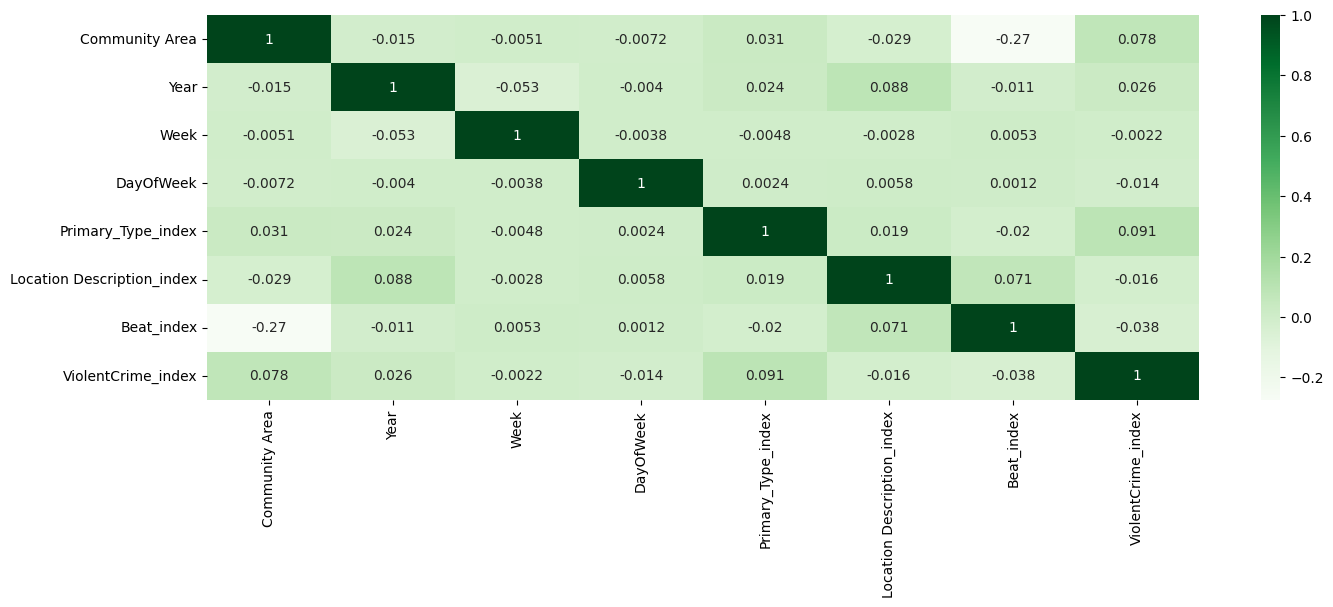

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix_df,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

Fit our data into the vectors

In [ ]:
vector_assembler = VectorAssembler(inputCols = ["Week",'DayOfWeek'], outputCol="features")
vector_assembled_df = vector_assembler.transform(transformed_df)
# vector_assembled_df.show()

In [ ]:
featureIndexer =  VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(vector_assembled_df)

In [ ]:
# labelIndexer = StringIndexer(inputCol="Primary_Type", outputCol="indexedLabel").fit(vector_assembled_df)
# labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
#                                labels=labelIndexer.labels)


labelIndexer = StringIndexer(inputCol="ViolentCrime", outputCol="indexedLabel").fit(vector_assembled_df)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# **Traing & Test Data**

Splitting the data into a training and a testing set with a ratio of 0.7 to 0.3 and configuring our model to utilize 100 decision trees and the Gini index to perform the right splits.

In [ ]:
(trainingData, testData) = vector_assembled_df.randomSplit([0.9, 0.1])
rf  = RandomForestClassifier(labelCol="indexedLabel",
                             featuresCol="indexedFeatures",
                             numTrees=100,impurity='gini', maxBins=128)


Create a pipeline to define the machine learning workflow and establish the different steps it will execute. This includes a Label Indexer, a Feature Indexer, a Random Forest model with the criterias we specified previously and a Label Converter

In [ ]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

Fit the pipeline into the training and testing data

In [ ]:
model = pipeline.fit(trainingData)
predictions = model.transform(testData)


**Model Evaluation**

Evaluate our model and establish how our classifier performed based on its accuracy and F1 score.

**Accuracy** = 0.213314

**F1 Score** = 0.075006

In [ ]:
# predictions.select("predictedLabel", "Primary_Type").show()

# evaluator = MulticlassClassificationEvaluator(
#     labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

# evaluator2 = MulticlassClassificationEvaluator(
#     labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


# accuracy = evaluator.evaluate(predictions)
# f1 = evaluator2.evaluate(predictions)


# print("accuracy = %g" % (accuracy))
# print("f1 score = %g" % (f1))

# predictions.groupBy("predictedLabel").count().show()




# predictions.select("predictedLabel", "ViolentCrime").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

# predictions.groupBy("predictedLabel").count().show()

accuracy = 0.537647
f1 score = 0.495844


Prepare the categorical column "Location Description" and transforms it using One Hot Encoder

In [ ]:

# from pyspark.ml.feature import OneHotEncoder
# locationIndexer = StringIndexer(inputCol="Location Description", outputCol="indexedLocation")\
#                 .fit(transformed_df)\
#                 .transform(transformed_df)
# encoded_data = OneHotEncoder(inputCols=["indexedLocation"],outputCols=["encodedLocation"])\
#         .fit(locationIndexer)\
#         .transform(locationIndexer)
# transformed_df.show()

+--------------------+--------------------+----+--------------+----+------------+----+---------+------------------+--------------------------+----------+------------------+
|        Primary_Type|Location Description|Beat|Community Area|Year|ViolentCrime|Week|DayOfWeek|Primary_Type_index|Location Description_index|Beat_index|ViolentCrime_index|
+--------------------+--------------------+----+--------------+----+------------+----+---------+------------------+--------------------------+----------+------------------+
|               THEFT|           RESIDENCE|0631|            44|2018|          No|  35|        7|               0.0|                       1.0|      14.0|               0.0|
|           NARCOTICS|              STREET|0233|            41|2018|          No|  31|        3|               3.0|                       0.0|     177.0|               0.0|
|     CRIMINAL DAMAGE|              STREET|2514|            19|2018|         Yes|  51|        4|               2.0|                    

**Executing the following steps**

*   Data preparation, model training, evaluation, and prediction.
*   Using a Random Forest Classifier to predict the type of crime that was commited by the individual. The accuracy and F1-score are used to evaluate our model.

**The findings**

*   Our model has an accuracy of approximately 32.55% indicating that our model correctly predicted about 32.55% of the instances in the test data.
*   Our F1 Score which evaluates the model in terms of both false positives and false negatives, turned out to be 0.216875.
*   Our model predicted the labels "THEFT" 1,331,379 times, "BATTERY"  608,987 times, and "NARCOTICS" 204,640 times.

**The count of "THEFT" predictions is significantly higher than the counts of other labels, indicating a potential class imbalance in the data**








In [ ]:
# transformed_df.cache()
# transformed_df.select(col('Block_index')).distinct().count()

In [ ]:
df_temp=transformed_df
all_cols = ['Beat_index','Location Description_index','Community Area']
# all_cols = ['Beat_index','Location Description_index','Community Area']
vector_assembler = VectorAssembler(inputCols = all_cols, outputCol="features")
df_temp = vector_assembler.transform(df_temp)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)

# labelIndexer = StringIndexer(inputCol="Primary_Type", outputCol="indexedLabel").fit(df_temp)
labelIndexer = StringIndexer(inputCol="ViolentCrime", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

(trainingData, testData) = df_temp.randomSplit([0.9, 0.1])
# rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini',maxBins=320)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

In [ ]:
predictions = model.transform(testData)
# predictions.select("predictedLabel", "Primary_Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)

print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

# predictions.groupBy("predictedLabel").count().show()

accuracy = 0.588899
f1 score = 0.579988


In [ ]:
# from pyspark.sql.types import IntegerType
# transformed_df = transformed_df.withColumn("Ward", transformed_df["Ward"].cast(IntegerType()))


In [ ]:
# from pyspark.ml.feature import OneHotEncoder
# locationIndexer = StringIndexer(inputCol="Location Description", outputCol="indexedLocation")\
#                 .fit(transformed_df)\
#                 .transform(transformed_df)
# encoded_data = OneHotEncoder(inputCols=["indexedLocation"],outputCols=["encodedLocation"])\
#         .fit(locationIndexer)\
#         .transform(locationIndexer)

Import the libraries

1.   CrossValidator (to perform cross-validation)
2.   ParamGridBuilder (to build a grid of hyperparameters)


**Tune hyperparameters using cross-validation to find the best-performing Random Forest model by trying different combinations. This will allow us to optimize the model's performance and improve upon the previous results**



In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

vector_assembler = VectorAssembler(inputCols = all_cols + ['DayOfWeek','Week'], outputCol="features")

indexed_data = vector_assembler.transform(transformed_df)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(indexed_data)


labelIndexer = StringIndexer(inputCol="ViolentCrime", outputCol="indexedLabel").fit(indexed_data)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = indexed_data.randomSplit([0.9, 0.1])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

paramGrid = ParamGridBuilder()\
            .addGrid(rf.numTrees, [3,10])\
            .addGrid(rf.maxBins, [320,340])\
            .addGrid(rf.maxDepth, [5,10])\
            .addGrid(rf.impurity,['gini','entropy'])\
            .build()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

crossval = CrossValidator(\
                          estimator=pipeline,\
                         estimatorParamMaps=paramGrid,\
                         evaluator=evaluator,\
                         numFolds=4)


model = crossval.fit(trainingData)


predictions = model.transform(testData)
# predictions.select("predictedLabel", "Primary_Type").show()

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)
print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

# predictions.groupBy("predictedLabel").count().show()

bestPipeline = model.bestModel
bestLRModel = bestPipeline.stages[2]
bestParams = bestLRModel.extractParamMap()
print("\n".join("{}\t{}".format(k, v) for k, v in bestParams.items()))

accuracy = 0.611381
f1 score = 0.604148
RandomForestClassifier_34174863d0af__bootstrap	True
RandomForestClassifier_34174863d0af__cacheNodeIds	False
RandomForestClassifier_34174863d0af__checkpointInterval	10
RandomForestClassifier_34174863d0af__featureSubsetStrategy	auto
RandomForestClassifier_34174863d0af__featuresCol	indexedFeatures
RandomForestClassifier_34174863d0af__impurity	entropy
RandomForestClassifier_34174863d0af__labelCol	indexedLabel
RandomForestClassifier_34174863d0af__leafCol	
RandomForestClassifier_34174863d0af__maxBins	320
RandomForestClassifier_34174863d0af__maxDepth	10
RandomForestClassifier_34174863d0af__maxMemoryInMB	256
RandomForestClassifier_34174863d0af__minInfoGain	0.0
RandomForestClassifier_34174863d0af__minInstancesPerNode	1
RandomForestClassifier_34174863d0af__minWeightFractionPerNode	0.0
RandomForestClassifier_34174863d0af__numTrees	10
RandomForestClassifier_34174863d0af__predictionCol	prediction
RandomForestClassifier_34174863d0af__probabilityCol	probability